In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }<|/style>"))

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC
from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq

import itertools
import sys
import re

from collections import Counter

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

####################################################################################################################################################################################

## [1] Load reference genome

####################################################################################################################################################################################

In [3]:
# load reference genome and reference annotation
reference_genome = '/home/rv76/Farhat_Lab/Reference_Seqs/H37Rv/h37rv.fasta'
for reference_genome in SeqIO.parse(reference_genome, "fasta"):
    reference_genome.seq.alphabet = IUPAC.unambiguous_dna

reference_genome_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/H37Rv/h37rv_genome_summary.txt', '\t').set_index('name')

# convert H37Rv sequence to a string
string = str(reference_genome.seq)

In [4]:
len(reference_genome.seq)

4411532

####################################################################################################################################################################################

## [2] Find short sequence repeat patterns (2-6bp short sequences with at least 3 repeats) in H37Rv genome 

####################################################################################################################################################################################

In [5]:
# get lists to store columns of what will become dataframe
start_index_list = []
SSR_motif_list = []
num_repeats_list = []
end_index_list = []

# iterate through different lengths for the simple sequence repeat motifs
for SSR_length in [2, 3, 4, 5, 6]:

    # get all combinations of bases for the length of this short sequence
    seq_combo_tuples = list(itertools.permutations(['A','C','G','T']*(SSR_length-1), SSR_length))
    seq_combo_strings = [''.join(x) for x in seq_combo_tuples]
    seq_combo_strings = list(set(seq_combo_strings))

    # iterate through each short sequence of this length
    for SS_i in seq_combo_strings:

        num_repeats = 3 # start with 3 repeats & increase

        # iterate through number of repeats for this simple sequence and find matches in ref genome
        pattern = SS_i*num_repeats
        start_indices_match = [match.start() for match in re.finditer(pattern, string)]

        # update lists
        start_index_list = start_index_list + list( np.array(start_indices_match) + 1 )
        SSR_motif_list = SSR_motif_list + [SS_i]*len(start_indices_match)
        num_repeats_list = num_repeats_list + [num_repeats]*len(start_indices_match)
        end_index_list = end_index_list + list( np.array(start_indices_match) + num_repeats*SSR_length )

        # keep increasing number of repeats until we don't find anymore in ref genome
        while len(start_indices_match) > 0:
            num_repeats += 1

            # iterate through number of repeats for this simple sequence and find matches in ref genome
            pattern = SS_i*num_repeats
            start_indices_match = [match.start() for match in re.finditer(pattern, string)]

            # update lists
            start_index_list = start_index_list + list( np.array(start_indices_match) + 1 )
            SSR_motif_list = SSR_motif_list + [SS_i]*len(start_indices_match)
            num_repeats_list = num_repeats_list + [num_repeats]*len(start_indices_match)
            end_index_list = end_index_list + list( np.array(start_indices_match) + num_repeats*SSR_length )
        
# concatenate lists into a DataFrame
SSR_H37Rv_df = pd.DataFrame()

SSR_H37Rv_df.loc[:,'H37Rv_start'] = start_index_list
SSR_H37Rv_df.loc[:,'H37Rv_end'] = end_index_list
SSR_H37Rv_df.loc[:,'motif'] = SSR_motif_list
SSR_H37Rv_df.loc[:,'repeats'] = num_repeats_list

# sort by Ref Pos, then by # repeats, drop duplicates and keep only row with largest num of repeats
SSR_H37Rv_df.sort_values(by = ['H37Rv_start','repeats'], ascending = [True,False], inplace = True)
SSR_H37Rv_df.drop_duplicates(subset = ['H37Rv_start','motif'], inplace = True, keep = 'first')

# reset index
SSR_H37Rv_df.reset_index(inplace = True, drop = True)

In [6]:
SSR_H37Rv_df.head()

,H37Rv_start,H37Rv_end,motif,repeats
0,561,569,CGC,3
1,562,570,GCC,3
2,643,648,AC,3
3,1121,1126,GC,3
4,1408,1413,CA,3


In [7]:
np.shape(SSR_H37Rv_df)

(18316, 4)

In [8]:
# count the number of motifs with >= 3 repeats found in H37Rv of each length: 2, 3, 4 ...
Counter(SSR_H37Rv_df.motif.apply(len))

Counter({2: 10989, 3: 7161, 4: 97, 5: 16, 6: 53})

In [9]:
SSR_H37Rv_df[SSR_H37Rv_df.motif.apply(len) == 5]

,H37Rv_start,H37Rv_end,motif,repeats
842,215864,215878,TCGGT,3
4977,1188073,1188087,GCGGC,3
4978,1188074,1188088,CGGCG,3
4979,1188075,1188089,GGCGC,3
4980,1188076,1188090,GCGCG,3
4981,1188077,1188091,CGCGG,3
5907,1398960,1398974,CGTCG,3
7826,1869363,1869377,CGGCG,3
7827,1869364,1869378,GGCGC,3
7828,1869365,1869379,GCGCG,3


#### save dataframe for downstream analysis

In [10]:
SSR_H37Rv_df.to_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/simple_sequence_repeat_regions/SSR_H37Rv_2-6bp_at_least_3_repeats.pkl')

####################################################################################################################################################################################

## [3] Analyze coverage of the H37Rv genome 

####################################################################################################################################################################################

In [11]:
SSR_H37Rv_df = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/simple_sequence_repeat_regions/SSR_H37Rv_2-6bp_at_least_3_repeats.pkl')

In [12]:
SSR_H37Rv_df.head()

,H37Rv_start,H37Rv_end,motif,repeats
0,561,569,CGC,3
1,562,570,GCC,3
2,643,648,AC,3
3,1121,1126,GC,3
4,1408,1413,CA,3


In [13]:
H37Rv_SSR_positions_list = []
for SSR_i_start, SSR_i_end in zip(SSR_H37Rv_df.H37Rv_start, SSR_H37Rv_df.H37Rv_end):
    
    SSR_i_H37Rv_coords = list(np.arange(SSR_i_start, SSR_i_end + 1))
    
    H37Rv_SSR_positions_list = H37Rv_SSR_positions_list + SSR_i_H37Rv_coords
    
H37Rv_SSR_positions_list = list(set(H37Rv_SSR_positions_list)) # remove duplicate positions from overlapping SSR regions

**Note:** use this number when describing how much of the genome is covered by SSR regions

In [14]:
len(H37Rv_SSR_positions_list)

99665

In [15]:
100.0 * (float(len(H37Rv_SSR_positions_list)) / float(len(reference_genome.seq)))

2.259192498206972

### Start at -1bp relative to the SSR track since that's where variants are usually called

In [16]:
SSR_H37Rv_df.loc[:, 'H37Rv_start'] = SSR_H37Rv_df.H37Rv_start - 1

In [17]:
SSR_H37Rv_df.head()

,H37Rv_start,H37Rv_end,motif,repeats
0,560,569,CGC,3
1,561,570,GCC,3
2,642,648,AC,3
3,1120,1126,GC,3
4,1407,1413,CA,3


#### save dataframe as excel sheet for publication

In [18]:
SSR_H37Rv_df.to_excel('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/simple_sequence_repeat_regions/SSR_H37Rv_2-6bp_at_least_3_repeats.xlsx')

**Note:** use this list when sorting INDEL variants that occur within an SSR region

In [19]:
H37Rv_SSR_positions_list = []
for SSR_i_start, SSR_i_end in zip(SSR_H37Rv_df.H37Rv_start, SSR_H37Rv_df.H37Rv_end):
    
    SSR_i_H37Rv_coords = list(np.arange(SSR_i_start, SSR_i_end + 1))
    
    H37Rv_SSR_positions_list = H37Rv_SSR_positions_list + SSR_i_H37Rv_coords
    
H37Rv_SSR_positions_list = list(set(H37Rv_SSR_positions_list)) # remove duplicate positions from overlapping SSR regions

In [20]:
len(H37Rv_SSR_positions_list)

112673

####################################################################################################################################################################################

## [4] Load in Homoplasy Scores from *TopDis (spacer length = 4)* for INDELs

####################################################################################################################################################################################

In [21]:
#load in INDELs
all_homoplasic_INDELs = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/homoplasies_detected_in_global_lineages/INDEL homoplasies/homoplasy_count_across_lineages_spacer_4.pkl')

In [22]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,1,2,3,4A,4B,4C,5,6,total,num_isolates
47371,4408100,GC,G,Antibiotic Resistance,gid,Rv3919c,103,del,frameshift,35,...,41.0,27.0,51.0,43.0,11.0,29.0,0.0,0.0,202.0,388
47365,4408087,CG,C,Antibiotic Resistance,gid,Rv3919c,116,del,frameshift,39,...,23.0,11.0,35.0,33.0,10.0,18.0,0.0,0.0,130.0,212
47313,4407851,GC,G,Antibiotic Resistance,gid,Rv3919c,352,del,frameshift,118,...,21.0,9.0,40.0,20.0,6.0,19.0,0.0,0.0,115.0,182
25151,2288850,A,ACC,Antibiotic Resistance,pncA,Rv2043c,392,ins,frameshift,131,...,1.0,14.0,6.0,3.0,6.0,2.0,0.0,0.0,32.0,48
47315,4407851,G,GC,Antibiotic Resistance,gid,Rv3919c,352,ins,frameshift,118,...,5.0,1.0,12.0,5.0,7.0,1.0,0.0,0.0,31.0,52


In [23]:
np.shape(all_homoplasic_INDELs)

(46306, 22)

Note - SNPs & INDELs with homoplasy score $ = 0$ were dropped from DataFrames

####################################################################################################################################################################################

## [5] Separate INDELs into those occcurring in HT regions, SSR regions and those not in either

####################################################################################################################################################################################

### HT

In [24]:
homopolymeric_regions_from_Luca = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/CSV_files/comparison_with_homopolymeric_regions/homopolymer regions from Luca/list_homopolymers_7bpmore_pure.csv')

create a set of all Reference Positions that occur within a Homopolymeric Tract

In [25]:
all_HT_ref_postions = []
for HT_i_start, HT_i_end in zip(homopolymeric_regions_from_Luca.chromStart, homopolymeric_regions_from_Luca.chromEnd):
    
    HT_i_ref_positions = range(HT_i_start, HT_i_end+1)
    all_HT_ref_postions = all_HT_ref_postions + HT_i_ref_positions
    
all_HT_ref_postions = set(all_HT_ref_postions)

In [26]:
len(all_HT_ref_postions)

1160

### SSR

set of all Reference Positions that occur within a SSR region (including positions at -1bp relative to SSR region)

In [27]:
H37Rv_SSR_positions = set(H37Rv_SSR_positions_list)

In [28]:
len(H37Rv_SSR_positions)

112673

### Annotate each INDEL based on whether it is in a SSR or HT or other

iterate through all INDELs and figure out which occur in SSR and those that don't

In [29]:
SSR_region_list = []
for indel_i_pos in all_homoplasic_INDELs.pos:
    
    if indel_i_pos in all_HT_ref_postions:
        SSR_region_list.append('HT')
    
    elif indel_i_pos in H37Rv_SSR_positions:
        SSR_region_list.append('yes')
        
    else:
        SSR_region_list.append('other')
        
all_homoplasic_INDELs.loc[:,'SSR_region'] = SSR_region_list

In [30]:
all_homoplasic_INDELs.head()

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,SSR_region
47371,4408100,GC,G,Antibiotic Resistance,gid,Rv3919c,103,del,frameshift,35,...,27.0,51.0,43.0,11.0,29.0,0.0,0.0,202.0,388,other
47365,4408087,CG,C,Antibiotic Resistance,gid,Rv3919c,116,del,frameshift,39,...,11.0,35.0,33.0,10.0,18.0,0.0,0.0,130.0,212,other
47313,4407851,GC,G,Antibiotic Resistance,gid,Rv3919c,352,del,frameshift,118,...,9.0,40.0,20.0,6.0,19.0,0.0,0.0,115.0,182,yes
25151,2288850,A,ACC,Antibiotic Resistance,pncA,Rv2043c,392,ins,frameshift,131,...,14.0,6.0,3.0,6.0,2.0,0.0,0.0,32.0,48,other
47315,4407851,G,GC,Antibiotic Resistance,gid,Rv3919c,352,ins,frameshift,118,...,1.0,12.0,5.0,7.0,1.0,0.0,0.0,31.0,52,yes


####################################################################################################################################################################################

## [6] Breakdown of INDELs by SSR region and type

####################################################################################################################################################################################

In [31]:
def get_homoplastic_INDEL_breakdown_stats(all_homoplasic_INDELs):
    
    print('(A1) INDELs in ncRNA')
    print(str(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.stop_codon == 'RNA'])[0]))
    print(str(float(sum(all_homoplasic_INDELs[all_homoplasic_INDELs.stop_codon == 'RNA'].total >= 2)) / float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.stop_codon == 'RNA'])[0])))
    print('')

    print('(A2) INDELs in intergenic')
    print(str(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.stop_codon == 'intergenic'])[0]))
    print(str(float(sum(all_homoplasic_INDELs[all_homoplasic_INDELs.stop_codon == 'intergenic'].total >= 2)) / float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.stop_codon == 'intergenic'])[0])))
    print('')

    print('(A3) INDELs in coding')
    print(str(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA')])[0]))
    print(str(float(sum(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA')].total >= 2)) / float(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA')])[0])))
    print('')

    print('(B1) INDELs in coding & inframe')
    print(str(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA') & (all_homoplasic_INDELs.INDEL_type == 'inframe')])[0]))
    print(str(float(sum(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA') & (all_homoplasic_INDELs.INDEL_type == 'inframe')].total >= 2)) / float(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA') & (all_homoplasic_INDELs.INDEL_type == 'inframe')])[0])))
    print('')

    print('(B2) INDELs in coding & frameshift')
    print(str(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0]))
    print(str(float(sum(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')].total >= 2)) / float(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon != 'intergenic') & (all_homoplasic_INDELs.stop_codon != 'RNA') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0])))
    print('')

    print('(C1) INDELs in coding & frameshift & no change to STOP')
    print(str(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'no change') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0]))
    try:
        print(str(float(sum(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'no change') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')].total >= 2)) / float(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'no change') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0])))
    except ZeroDivisionError:
        print('ZeroDivisionError: float division by zero')
    print('')

    print('(C2) INDELs in coding & frameshift & premature STOP first 3/4 of gene')
    print(str(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'premature stop - first 3/4') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0]))
    print(str(float(sum(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'premature stop - first 3/4') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')].total >= 2)) / float(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'premature stop - first 3/4') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0])))
    print('')

    print('(C3) INDELs in coding & frameshift & premature STOP last 1/4 of gene')
    print(str(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'premature stop - last 1/4') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0]))
    print(str(float(sum(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'premature stop - last 1/4') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')].total >= 2)) / float(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'premature stop - last 1/4') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0])))
    print('')

    print('(C4) INDELs in coding & frameshift & elongation STOP appears after annotated STOP')
    print(str(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'elongation - appears after annotated stop') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0]))
    print(str(float(sum(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'elongation - appears after annotated stop') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')].total >= 2)) / float(np.shape(all_homoplasic_INDELs[(all_homoplasic_INDELs.stop_codon == 'elongation - appears after annotated stop') & (all_homoplasic_INDELs.INDEL_type == 'frameshift')])[0])))

## [6.1] all INDELs

In [32]:
np.shape(all_homoplasic_INDELs)

(46306, 23)

In [33]:
float(sum(all_homoplasic_INDELs.total >= 2)) / float(np.shape(all_homoplasic_INDELs)[0])

0.1143048417051786

## [6.2] INDELs *in* HT regions

In [34]:
np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'HT'])

(330, 23)

In [35]:
float(sum(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'HT'].total >= 2)) / float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'HT'])[0])

0.7515151515151515

In [36]:
get_homoplastic_INDEL_breakdown_stats(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'HT'])

(A1) INDELs in ncRNA
3
1.0

(A2) INDELs in intergenic
67
0.761194029851

(A3) INDELs in coding
260
0.746153846154

(B1) INDELs in coding & inframe
30
0.566666666667

(B2) INDELs in coding & frameshift
230
0.769565217391

(C1) INDELs in coding & frameshift & no change to STOP
0
ZeroDivisionError: float division by zero

(C2) INDELs in coding & frameshift & premature STOP first 3/4 of gene
117
0.777777777778

(C3) INDELs in coding & frameshift & premature STOP last 1/4 of gene
60
0.783333333333

(C4) INDELs in coding & frameshift & elongation STOP appears after annotated STOP
53
0.735849056604


## [6.3] INDELs *in* SSR regions

In [37]:
np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'yes'])

(2077, 23)

In [38]:
float(sum(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'yes'].total >= 2)) / float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'yes'])[0])

0.2585459797785267

In [39]:
get_homoplastic_INDEL_breakdown_stats(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'yes'])

(A1) INDELs in ncRNA
8
0.0

(A2) INDELs in intergenic
246
0.191056910569

(A3) INDELs in coding
1823
0.268787712562

(B1) INDELs in coding & inframe
842
0.407363420428

(B2) INDELs in coding & frameshift
981
0.149847094801

(C1) INDELs in coding & frameshift & no change to STOP
2
0.5

(C2) INDELs in coding & frameshift & premature STOP first 3/4 of gene
570
0.145614035088

(C3) INDELs in coding & frameshift & premature STOP last 1/4 of gene
229
0.157205240175

(C4) INDELs in coding & frameshift & elongation STOP appears after annotated STOP
180
0.15


## [6.4] INDELs *not in* HT or SSR regions

In [40]:
np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'other'])

(43899, 23)

In [41]:
float(sum(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'other'].total >= 2)) / float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'other'])[0])

0.10269026629308185

In [42]:
get_homoplastic_INDEL_breakdown_stats(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'other'])

(A1) INDELs in ncRNA
216
0.180555555556

(A2) INDELs in intergenic
7198
0.12461794943

(A3) INDELs in coding
36485
0.0979032479101

(B1) INDELs in coding & inframe
4806
0.0801081980857

(B2) INDELs in coding & frameshift
31679
0.100602923072

(C1) INDELs in coding & frameshift & no change to STOP
66
0.181818181818

(C2) INDELs in coding & frameshift & premature STOP first 3/4 of gene
19143
0.100558951053

(C3) INDELs in coding & frameshift & premature STOP last 1/4 of gene
7404
0.0953538627769

(C4) INDELs in coding & frameshift & elongation STOP appears after annotated STOP
5066
0.107382550336


## [6.5] $\sum{Hs}$ for FS in HT regions as a proportion of $\sum{Hs}$ for FS across genome

In [46]:
all_homoplasic_INDELs[all_homoplasic_INDELs.INDEL_type == 'frameshift'].shape

(39844, 23)

In [50]:
all_homoplasic_INDELs[all_homoplasic_INDELs.INDEL_type == 'frameshift'].total.sum()

71351.0

In [53]:
all_homoplasic_INDELs[(all_homoplasic_INDELs.INDEL_type == 'frameshift')&(all_homoplasic_INDELs.SSR_region == 'HT')].shape

(294, 23)

In [54]:
all_homoplasic_INDELs[(all_homoplasic_INDELs.INDEL_type == 'frameshift')&(all_homoplasic_INDELs.SSR_region == 'HT')].total.sum()

10405.0

In [55]:
(float(10405) / float(71351))*100.0

14.582836960939579

## [6.6] proportion of INDELs with $Hs \ge X$ for varying values of X

In [33]:
Hs_thresholds = np.arange(1, 51)
INDELs_HT_prop_list = []
INDELs_SSR_prop_list = []
INDELs_other_prop_list = []

for Hs_i in Hs_thresholds:
    
    INDELs_HT_prop_list.append(float(sum(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'HT'].total >= Hs_i)) / float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'HT'])[0]))
    INDELs_SSR_prop_list.append(float(sum(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'yes'].total >= Hs_i)) / float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'yes'])[0]))
    INDELs_other_prop_list.append(float(sum(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'other'].total >= Hs_i)) / float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'other'])[0]))

In [34]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

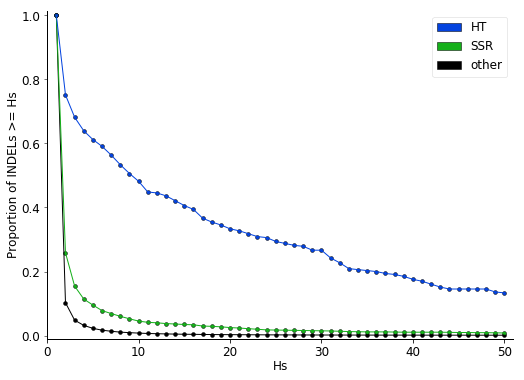

In [56]:
fig, ax = plt.subplots()

ax.plot(Hs_thresholds, INDELs_other_prop_list, color = 'xkcd:black', linewidth = 1.0)
ax.scatter(Hs_thresholds, INDELs_other_prop_list, color = 'xkcd:black', linewidth = 0.5, s = 15, edgecolor = 'k')

ax.plot(Hs_thresholds, INDELs_SSR_prop_list, color = 'xkcd:green', linewidth = 1.0)
ax.scatter(Hs_thresholds, INDELs_SSR_prop_list, color = 'xkcd:green', linewidth = 0.5, s = 15, edgecolor = 'k')

ax.plot(Hs_thresholds, INDELs_HT_prop_list, color = 'xkcd:blue', linewidth = 1.0)
ax.scatter(Hs_thresholds, INDELs_HT_prop_list, color = 'xkcd:blue', linewidth = 0.5, s = 15, edgecolor = 'k')

# ax.set_title('Distribution of Homoplasy\nScores for 330 INDELs', fontsize = 10, color = 'k', pad = -10)
ax.set_xlabel('Hs', fontsize = 12, color = 'k', labelpad = 1)
ax.set_ylabel('Proportion of INDELs >= Hs' , fontsize = 12, color = 'k', labelpad = 1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(False)

ax.tick_params(labelcolor = 'k')
ax.set_xlim(0, 51)
ax.set_ylim(-0.01, 1.015)

ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

#create legend
HT = 'xkcd:blue'
SSR = 'xkcd:green'
other = 'xkcd:black'

handles = [Rectangle((0,0),1,1,color=c,ec="k") for c in [HT,SSR,other]]
labels = ["HT","SSR","other"]
ax.legend(handles, labels, fontsize=12)


fig = plt.gcf()
fig.set_size_inches(7.5, 5.5)
fig.tight_layout()

file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/for publication/HT_SSR_other_proportion_INDELs_Hs.pdf'
## plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True) # incorporated into manhattan panel

plt.show()

In [57]:
str(float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'other'])[0]))

'43899.0'

In [58]:
str(float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'yes'])[0]))

'2077.0'

In [59]:
str(float(np.shape(all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'HT'])[0]))

'330.0'

####################################################################################################################################################################################

## [7] check INDELs in SSR regions with highest homoplasy score

####################################################################################################################################################################################

In [41]:
all_SSR_homoplasic_INDELs = all_homoplasic_INDELs[all_homoplasic_INDELs.SSR_region == 'yes']

In [42]:
all_SSR_homoplasic_INDELs.sort_values(by='total', ascending = False).head(n = 25)

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,ins_del,INDEL_type,codon_pos,...,2,3,4A,4B,4C,5,6,total,num_isolates,SSR_region
752,55540,G,GCCGCCGCCT,Non-Essential,ponA1,Rv0050,1878,ins,inframe,626,...,272.0,0.0,0.0,0.0,0.0,6.0,5.0,397.0,2238,yes
34894,3247864,C,CTAGG,Non-Essential,ppsA,Rv2931,2420,ins,frameshift,807,...,90.0,12.0,66.0,79.0,38.0,1.0,3.0,324.0,469,yes
17487,1625332,C,CGGT,Essential,opcA,Rv1446c,34,ins,inframe,12,...,184.0,2.0,0.0,0.0,0.0,0.0,0.0,186.0,5157,yes
756,55543,G,GCCGCCT,Non-Essential,ponA1,Rv0050,1881,ins,inframe,627,...,2.0,149.0,0.0,0.0,0.0,0.0,0.0,153.0,1322,yes
41519,3969423,GGCC,G,PE/PPE,PPE61,Rv3532,81,del,inframe,27,...,25.0,21.0,22.0,17.0,37.0,2.0,0.0,151.0,1289,yes
40873,3895244,G,GGCC,PE/PPE,PPE60,Rv3478,819,ins,inframe,273,...,1.0,0.0,0.0,16.0,3.0,0.0,0.0,133.0,963,yes
37345,3528971,TCGC,T,PE/PPE,PPE53,Rv3159c,193,del,inframe,65,...,40.0,32.0,22.0,2.0,3.0,2.0,0.0,128.0,435,yes
30979,2873093,G,GCCA,Essential,Rv2553c,Rv2553c,173,ins,inframe,58,...,20.0,12.0,31.0,16.0,10.0,0.0,0.0,120.0,732,yes
47313,4407851,GC,G,Antibiotic Resistance,gid,Rv3919c,352,del,frameshift,118,...,9.0,40.0,20.0,6.0,19.0,0.0,0.0,115.0,182,yes
10908,968965,GCGC,G,PE/PPE,PE_PGRS15,Rv0872c,1280,del,inframe,427,...,25.0,12.0,12.0,14.0,19.0,1.0,0.0,100.0,440,yes


In [49]:
all_SSR_homoplasic_INDELs.loc[45928,:]

pos                    4348820
ref                          G
alt                        GGC
gene_category             None
gene_name        eccCa1_eccCb1
gene_id          Rv3870_Rv3871
gene_pos                  None
ins_del                    ins
INDEL_type          frameshift
codon_pos                 None
stop_codon          intergenic
key              G_4348820_GGC
1                            0
2                            0
3                           38
4A                           0
4B                           0
4C                           0
5                            0
6                            0
total                       38
num_isolates               199
SSR_region                 yes
Name: 45928, dtype: object

*ponA1*

In [43]:
SSR_H37Rv_df[(SSR_H37Rv_df.H37Rv_start <= 55540) & (SSR_H37Rv_df.H37Rv_end >= 55533)]

,H37Rv_start,H37Rv_end,motif,repeats
236,55533,55554,GCC,7
237,55533,55551,GCCGCC,3
238,55534,55555,CCG,7
239,55534,55552,CCGCCG,3
240,55535,55553,CGC,6
241,55535,55553,CGCCGC,3


*gid*

In [44]:
SSR_H37Rv_df[(SSR_H37Rv_df.H37Rv_start <= 4407851) & (SSR_H37Rv_df.H37Rv_end >= 4407851)

,H37Rv_start,H37Rv_end,motif,repeats
18303,4407846,4407852,GC,3


*PPE60*

In [45]:
SSR_H37Rv_df[(SSR_H37Rv_df.H37Rv_start <= 3895244) & (SSR_H37Rv_df.H37Rv_end >= 3895244)]

,H37Rv_start,H37Rv_end,motif,repeats
16191,3895236,3895245,CGG,3
16192,3895237,3895246,GGC,3


*PPE18*

In [46]:
SSR_H37Rv_df[(SSR_H37Rv_df.H37Rv_start <= 1340167) & (SSR_H37Rv_df.H37Rv_end >= 1340167)]

,H37Rv_start,H37Rv_end,motif,repeats
5655,1340159,1340168,CGG,3
5656,1340160,1340169,GGC,3


*ppsA*

In [47]:
SSR_H37Rv_df[(SSR_H37Rv_df.H37Rv_start <= 3247864) & (SSR_H37Rv_df.H37Rv_end >= 3247864)]

,H37Rv_start,H37Rv_end,motif,repeats
13542,3247858,3247866,GC,4
13543,3247859,3247865,CG,3
